In [1]:
# Load all dependencies
! pip install -q transformers
! pip install -q datasets
! pip install -q peft
! pip install -q -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 10.1 MB/s eta 0:00:00


In [2]:
# Importing all important libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from sklearn import metrics

import transformers
from transformers import (
    AutoTokenizer,
    RobertaModel
)

import datasets
from datasets import (
    load_from_disk,
    load_dataset
)

import torch
from torch import cuda
from torch.utils.data import (
    Dataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)

In [3]:
# See if cuda is activated for training
device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


In [4]:
# Import database
dataset = load_dataset('bigbio/hallmarks_of_cancer')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [5]:
# Show dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['document_id', 'text', 'label'],
        num_rows: 12119
    })
    test: Dataset({
        features: ['document_id', 'text', 'label'],
        num_rows: 3547
    })
    validation: Dataset({
        features: ['document_id', 'text', 'label'],
        num_rows: 1798
    })
})

In [6]:
# Document ID irrelevant for training so remove
dataset.remove_columns('document_id')

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 12119
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3547
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1798
    })
})

In [7]:
# Concatenate train, validation, test for new dataset
new_df1 = pd.DataFrame(dataset['train'])
new_df2 = pd.DataFrame(dataset['validation'])
new_df3 = pd.DataFrame(dataset['test'])

# Concatenate every dataframe
new_df = pd.concat([new_df1, new_df2, new_df3])

In [8]:
# Remove document_id once again
new_df.drop(['document_id'], axis=1, inplace=True)

In [9]:
# Show new dataframe
new_df.head()

,text,label
0,Hypoxic events frequently occur in the aquatic...,[7]
1,Only a few studies are however available on th...,[7]
2,"To elucidate the phenomenon , mirror carp Cypr...",[7]
3,( 16.13-16.22 g ) were exposed chronically to ...,[7]
4,Level of oxidative DNA damage ( as determined ...,[7]


In [10]:
nums = set()
nums_dict = {}

for i in range(len(new_df)):
  output = new_df.iloc[i][1]
  for n in output:
    nums.add(n)
    nums_dict[n] = nums_dict.get(n, 0) + 1

# Show unique labels and count of each label
print("Unique Labels:", nums)
print("Count of each unique labels:", nums_dict)

Unique Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Count of each unique labels: {7: 13010, 10: 226, 4: 832, 8: 358, 9: 993, 5: 667, 6: 768, 1: 518, 3: 213, 0: 366, 2: 295}


In [11]:
# One-hot-encode output labels
for i in range(len(new_df)):
  output = new_df.iloc[i, 1]
  one_hot_output = [0] * 11
  for n in output:
    one_hot_output[n] = 1

  new_df.iloc[i][1] = one_hot_output

In [12]:
# Show new dataframe
new_df.head()

,text,label
0,Hypoxic events frequently occur in the aquatic...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,Only a few studies are however available on th...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,"To elucidate the phenomenon , mirror carp Cypr...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,( 16.13-16.22 g ) were exposed chronically to ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,Level of oxidative DNA damage ( as determined ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [13]:
# Majority is [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
only = [0] * 11
only[7] += 1

# Flag to see if output is majority
flag = []

for i in range(len(new_df)):
  o = new_df.iloc[i, 1]
  if o == only:
    flag.append(1)
  else:
    flag.append(0)

In [14]:
# Create new column to detect majority class
new_df['majority_class'] = flag

In [15]:
# Show dataframe again
new_df.head()

,text,label,majority_class
0,Hypoxic events frequently occur in the aquatic...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
1,Only a few studies are however available on th...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
2,"To elucidate the phenomenon , mirror carp Cypr...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
3,( 16.13-16.22 g ) were exposed chronically to ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1
4,Level of oxidative DNA damage ( as determined ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1


In [16]:
# Find the rows corresponding to the majority class
majority = new_df[new_df['majority_class']==1]
minority = new_df[new_df['majority_class']==0]

In [17]:
# Determine the number of rows you want to sample from the majority class
sample_size = 1000

# Perform random undersampling
sampled = majority.sample(n=sample_size)

In [18]:
# Create new dataframe with random under sampling
df = pd.concat([sampled, minority])

In [19]:
# Drop majoriry class
df.drop(columns=['majority_class'], axis=1, inplace=True)

In [20]:
# Make sure index is reset after dropping rows
df = df.reset_index(drop=True)

In [21]:
# Show new dataframe
df.head()

,text,label
0,Correlating with the antimetastatic effect mea...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,We conclude that stromal PDGFRα inhibition rep...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,We explored the therapeutic possibilities by c...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,Arylamine-modified dG lesions were studied in ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,Ectopic expression of miR-125b inhibited SUV39...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [22]:
# Download RoBERTa base tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [23]:
# Max tokens counter
max_tokens = 0

# Find max tokens
for sentence in df['text']:
    # Tokenize the sentence
    tokens = tokenizer.tokenize(sentence)

    # Count the tokens in the sentence
    num_tokens = len(tokens)

    # Update the maximum token count if necessary
    max_tokens = max(max_tokens, num_tokens)

print("Maximum number of tokens in the sentences:", max_tokens)

Maximum number of tokens in the sentences: 192


In [24]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05

In [25]:
# Create class to tokenize dataframe
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['text']
        self.targets = dataframe['label']
        self.max_len = max_len

    def __len__(self):
      return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [26]:
# Creating the dataset and dataloader for RoBERTa

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)

# Reset index after dropping
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("Full Dataset: {}".format(df.shape))
print("Train Dataset: {}".format(train_dataset.shape))
print("Validation Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

Full Dataset: (5454, 2)
Train Dataset: (4363, 2)
Validation Dataset: (1091, 2)


In [27]:
# Training parameters
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

# Validation parameters
valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

# Make data loaders for training
training_loader = DataLoader(training_set, **train_params)
valid_loader = DataLoader(testing_set, **valid_params)

In [28]:
# RoBERTa class for multi-labeling
class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids):
        _,x= self.l1(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.l2(x)
        output = self.l3(x)
        return output

model = RoBERTaClass()

# Utilize Cuda GPU for training
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [29]:
# Initialize optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [30]:
# Get loss function
def get_loss(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [31]:
training_loss = []
valid_loss = []

# Train model
for epoch in range(EPOCHS):
    model.train()
    for i ,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)

        t_loss = get_loss(outputs, targets)
        training_loss.append(t_loss.cpu().item())

        t_loss.backward()
        optimizer.step()

    # Get validation loss while training
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)

            v_loss = get_loss(outputs, targets)
            valid_loss.append(v_loss.cpu().item())

    print(f'Epoch: {epoch}, Train Loss:  {t_loss.item()}')
    print(f'Epoch: {epoch}, Val Loss {v_loss.item()}\n')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Train Loss:  0.16142302751541138
Epoch: 0, Val Loss 0.19219908118247986

Epoch: 1, Train Loss:  0.07448691129684448
Epoch: 1, Val Loss 0.08268356323242188

Epoch: 2, Train Loss:  0.05074727162718773
Epoch: 2, Val Loss 0.044009774923324585

Epoch: 3, Train Loss:  0.03446422144770622
Epoch: 3, Val Loss 0.17042668163776398

Epoch: 4, Train Loss:  0.03774632140994072
Epoch: 4, Val Loss 0.22895695269107819



In [32]:
avg_train = []
avg_valid = []
window_train = 78
window_valid = 36

# Make windows so that loss function could be plotted
for i in range(0, len(training_loss), window_train):
    subset = training_loss[i:i+window_train]
    avg = np.mean(subset)
    avg_train.append(avg)

for i in range(0, len(valid_loss), window_valid):
    subset = valid_loss[i:i+window_valid]
    avg = np.mean(subset)
    avg_valid.append(avg)

In [33]:
# Create bins for training loss
bins_train = np.linspace(0, EPOCHS, len(avg_train))

In [34]:
# Create bins for validation loss
bins_valid = np.linspace(0, EPOCHS, len(avg_valid))

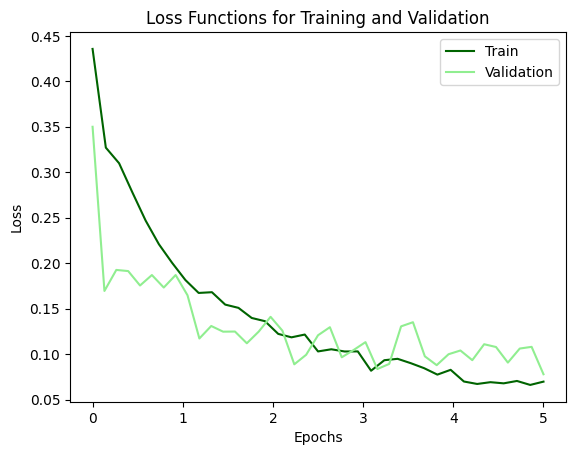

In [35]:
plt.plot(bins_train, avg_train, color='darkgreen', label='Train')
plt.plot(bins_valid, avg_valid, color='lightgreen', label='Validation')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Functions for Training and Validation')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [36]:
# Download loss function graph as jpeg
plt.savefig('losses.jpg', format='jpeg')

<Figure size 640x480 with 0 Axes>

In [37]:
fin_targets = []
fin_outputs = []

# Get accuracy from testing data
def test():
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = get_loss(outputs, targets)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [38]:
outputs, targets = test()

# Threshold kept at 0.5
outputs = np.array(outputs) >= 0.5

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
precision = metrics.precision_score(targets, outputs, average='weighted')
recall = metrics.recall_score(targets, outputs, average='weighted')

print(f"Accuracy Score: {accuracy}")
print(f"F1 Score (Macro): {f1_score_macro}")
print(f"F1 Score (Micro): {f1_score_micro}")
print(f"Precision (Weighted): {precision}")
print(f"Recall (Weighted): {recall}")

Accuracy Score: 0.9234300433234532
F1 Score (Macro): 0.8472552852933283
F1 Score (Micro): 0.8401639344262295
Precision (Weighted): 0.86157944197985
Recall (Weighted): 0.8186900958466453


In [42]:
# create confusion matrix
def plot_confusion_matrix(cm, target_names, title, color, normalize):
    # convert list to numpy array
    cm = np.asarray(cm)

    # find accuracy
    accuracy = np.trace(cm) / float(np.sum(cm))     #trace sums diagonals of cm, dividing by total sum gets accuracy
    misclass = 1 - accuracy                         #inaccuracy

    # get color map
    cmap = plt.get_cmap(color)

    # display plot
    plt.figure(figsize=(8, 6))

    plt.imshow(
        cm,
        interpolation='nearest',
        cmap=cmap
    )

    plt.title(title)
    plt.colorbar()

    # shows 'ticks' or label values on axes of plot
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names,
               rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 ("{:0.4f}".format(cm[i, j]) if normalize else "{:,}".format(cm[i, j])),
                 horizontalalignment="center",
                 color="white" if i == 0 and j == 0 else "black")


    plt.tight_layout()
    plt.ylabel('Target Label')
    plt.xlabel('Predicted Label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

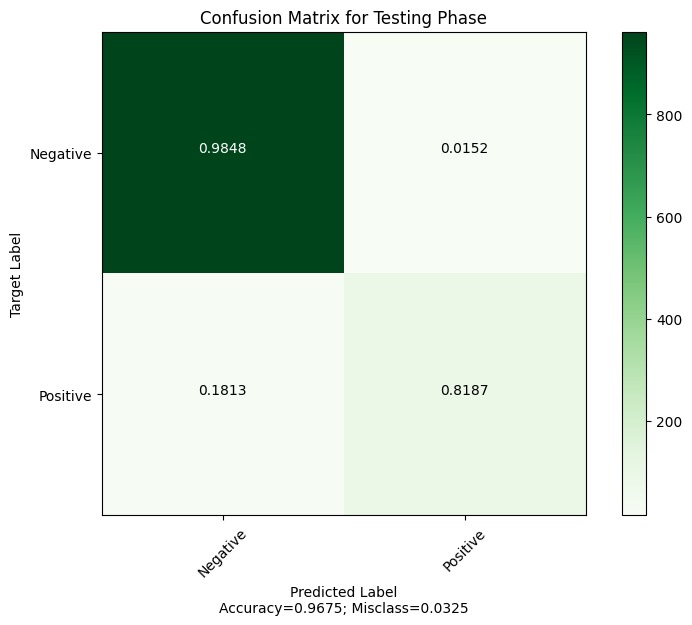

In [43]:
# Create and process confusion matrix
c_matrix = metrics.multilabel_confusion_matrix(targets, outputs, labels=range(11))
fin_c_matrix = [
    [0, 0],
    [0, 0]
]

# Aggregate all confusion matrices
for _, mat in enumerate(c_matrix):
    for n in range(2):
        for m in range(2):
            fin_c_matrix[n][m] += mat[n][m]

# Average sum of all confusion matrices
for n in range(2):
    for m in range(2):
        # 11 confusion matrices
        fin_c_matrix[n][m] /= 11

# visualize confusion matrix (as numpy array) with function
plot_confusion_matrix(
    fin_c_matrix,
    target_names=['Negative', 'Positive'],
    color='Greens',
    title='Confusion Matrix for Testing Phase',
    normalize=True
)